### Imports

In [1]:
# setup vulkan
!mkdir -p /usr/share/vulkan/icd.d
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json
!mv nvidia_icd.json /usr/share/vulkan/icd.d
!mv 10_nvidia.json /usr/share/glvnd/egl_vendor.d/10_nvidia.json
!apt-get install -y --no-install-recommends libvulkan-dev
# dependencies
!pip install --upgrade mani_skill tyro
!pip install sapien

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libvulkan1
Recommended packages:
  mesa-vulkan-drivers | vulkan-icd
The following NEW packages will be installed:
  libvulkan-dev libvulkan1
0 upgraded, 2 newly installed, 0 to remove and 18 not upgraded.
Need to get 1,020 kB of archives.
After this operation, 17.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan1 amd64 1.3.204.1-2 [128 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan-dev amd64 1.3.204.1-2 [892 kB]
Fetched 1,020 kB in 2s (527 kB/s)
Selecting previously unselected package libvulkan1:amd64.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../libvulkan1_1.3.204.1-2_amd64.deb ...
Unpacking libvulkan1:amd64 (1.3.204.1-2) ...
Selecting previously unselected package libvulkan-dev:amd64.
Preparing to unpa

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    site.main() # run this so local pip installs are recognized

### Check

In [3]:
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 512 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("PickCube-v1", num_envs=num_envs, obs_mode="rgbd")
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

Download complete.
# -------------------------------------------------------------------------- #
Task ID: PickCube-v1, 512 parallel environments, sim_backend=physx_cuda
obs_mode=rgbd, control_mode=pd_joint_delta_pos
render_mode=None, sensor_details=RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Dict('agent': Dict('qpos': Box(-inf, inf, (512, 9), float32), 'qvel': Box(-inf, inf, (512, 9), float32)), 'extra': Dict('is_grasped': Box(False, True, (512,), bool), 'tcp_pose': Box(-inf, inf, (512, 7), float32), 'goal_pos': Box(-inf, inf, (512, 3), float32)), 'sensor_param': Dict('base_camera': Dict('extrinsic_cv': Box(-inf, inf, (512, 3, 4), float32), 'cam2world_gl': Box(-inf, inf, (512, 4, 4), float32), 'intrinsic_cv': Box(-inf, inf, (512, 3, 3), float32))), 'sensor_data': Dict('base_camera': Dict('rgb': Box(0, 255, (512, 128, 128, 3), uint8), 'depth': Box(-32768, 32767, (512, 128, 128, 1), int16))))
(single) action space: Box(-1.0, 1.0, (8,), float32)
# ---------------------

dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data'])
dict_keys(['base_camera'])
dict_keys(['rgb', 'depth'])
torch.Size([512, 128, 128, 3])


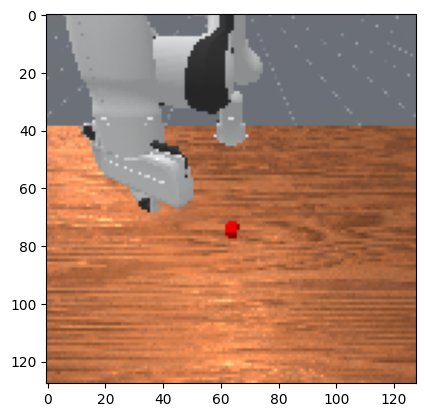

In [4]:
# visualize the image data from the environment and inspect the data
print(obs.keys())
print(obs['sensor_data'].keys())
print(obs['sensor_data']['base_camera'].keys())
print(obs['sensor_data']['base_camera']['rgb'].shape)
import matplotlib.pyplot as plt
plt.imshow(obs['sensor_data']['base_camera']['rgb'][0].cpu().numpy())

### Shit class
Right here you need to change MyEnv to smth other if updating


In [18]:
from mani_skill.envs.tasks.empty_env import EmptyEnv
from mani_skill.envs.sapien_env import BaseEnv

from typing import Dict

from mani_skill.agents.robots.fetch import FETCH_WHEELS_COLLISION_BIT
from mani_skill.utils.building.ground import build_ground
# from mani_skill.utils.scene_builder import SceneBuilder
from mani_skill.utils.registration import register_env
from mani_skill.utils import common, sapien_utils
import sapien
from mani_skill.sensors.camera import CameraConfig

import os
import json
import numpy as np
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm import tqdm
from mani_skill.utils.wrappers import RecordEpisode
from transforms3d import quaternions
import random
import string

def generate_random_string(length=10):
    characters = string.ascii_letters + string.digits
    return ''.join(random.choice(characters) for _ in range(length))

def process_string(s):
    if '_' in s:
        return s.split('_',1)[0] + '.obj'
    if '.' in s:
        return s.split('.',1)[0] + '.obj'
    return s + '.obj'

def temp_process_string(s):
    """Временно, чтобы старый нейминг работал"""
    for i, char in enumerate(s):
        if char in "_." or char.isdigit():
            return s[:i] + ".obj"
    return s + ".obj"

def get_absolute_matrix(node, nodes_dict):
    current_matrix = np.array(node[2]["matrix"])
    parent_name = node[0]
    while parent_name != "world":
        print(f"Doing GOIDA IN PROCESS for name {node[1]} with parent {node[0]}")
        parent_node = nodes_dict[parent_name]
        parent_matrix = np.array(parent_node[2]["matrix"])
        current_matrix = parent_matrix @ current_matrix
        parent_name = parent_node[0]
    return current_matrix


ENV_NAME = generate_random_string()

@register_env(ENV_NAME, max_episode_steps=200000)
class OurEnv(BaseEnv):
    SUPPORTED_REWARD_MODES = ["none"]
    """
    This is just a very smart environment for goida transformation from ss
    """

    def __init__(self, *args, robot_uids="panda", **kwargs):
        super().__init__(*args, robot_uids=robot_uids, **kwargs)

    @property
    def _default_sensor_configs(self):
        pose = sapien_utils.look_at([1.25, -1.25, 1.5], [0.0, 0.0, 0.2])
        return [CameraConfig("base_camera", pose, 256, 256, np.pi / 2, 0.01, 100)]

    @property
    def _default_human_render_camera_configs(self):
        pose = sapien_utils.look_at([3.5, 3.5, 1], [0.0, 0.0, 0.35])
        return CameraConfig(
            "render_camera", pose=pose, width=512, height=512, fov=1, near=0.01, far=100
        )

    def _load_agent(self, options: dict):
        super()._load_agent(options, sapien.Pose(p=[-0.615, 0, 0]))

    def _load_scene(self, options: dict):
        self.ground = build_ground(self.scene)
        self.ground.set_collision_group_bit(group=2, bit_idx=30, bit=1)
        self._load_scene_from_json(options)


    def _get_pq(self, matrix, origin):
        matrix = np.array(matrix)
        q = quaternions.mat2quat(matrix[:3,:3])
        p = matrix[:-1, 3] - origin
        return p, q
    
    def _load_scene_from_json(self, options: dict):
        super()._load_scene(options)
        self.actors = []

        assets_dir = options.get("assets_dir", "./assets/")
        scale = np.array(options.get("scale", [1.0, 1.0, 1.0]))
        origin = np.array(options.get("origin", [0.0, 1.0, 0.0]))

        with open('customize.json', "r") as f: # big_scene , one_shelf_many_milk_scene , customize
            data = json.load(f)

        nodes_dict = {}
        for node in data["graph"]:
            nodes_dict[node[1]] = node

        for node in data["graph"]:
            parent_name, obj_name, props = node
            if ('/' not in obj_name):
                abs_matrix = get_absolute_matrix(node, nodes_dict)

                p, q = self._get_pq(abs_matrix, origin)

                asset_file = os.path.join(assets_dir, temp_process_string(obj_name))
                if not os.path.exists(asset_file):
                    asset_file = os.path.splitext(asset_file)[0] + ".glb"

                if not os.path.exists(asset_file):
                    print("Not found file for " + obj_name + " =(" + " ( " + asset_file + " )")
                else:
                    # print("Found file for " + obj_name + " =)" + " ( " + asset_file + " )")
                    builder = self.scene.create_actor_builder()
                    builder.add_visual_from_file(filename=asset_file, scale=scale)
                    builder.set_initial_pose(sapien.Pose(p=p, q=q))

                    if obj_name.startswith('shelf'):
                        builder.add_nonconvex_collision_from_file(filename=asset_file, scale=scale)
                        actor = builder.build_static(name=obj_name)
                    else:
                        builder.add_convex_collision_from_file(filename=asset_file, scale=scale)
                        actor = builder.build(name=obj_name)

                    self.actors.append(actor)





    def _initialize_episode(self, env_idx: torch.Tensor, options: dict):
        if self.robot_uids == "fetch":
            qpos = np.array(
                [
                    0,
                    0,
                    0,
                    0.386,
                    0,
                    0,
                    0,
                    -np.pi / 4,
                    0,
                    np.pi / 4,
                    0,
                    np.pi / 3,
                    0,
                    0.015,
                    0.015,
                ]
            )
            self.agent.reset(qpos)
            self.agent.robot.set_pose(sapien.Pose([10.0, 10, 0.0]))

            self.ground.set_collision_group_bit(
                group=2, bit_idx=FETCH_WHEELS_COLLISION_BIT, bit=1
            )
        else:
            raise NotImplementedError


    def evaluate(self):
        return {}

    def _get_obs_extra(self, info: Dict):
        return dict()


env = gym.make(ENV_NAME, robot_uids='fetch', num_envs=1, render_mode="rgb_array", enable_shadow=True)

env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    # on GPU sim we record intervals, not by single episodes as there are multiple envs
    # each 100 steps a new video is saved
    max_steps_per_video=100
)

# step through the environment with random actions
obs, _ = env.reset()


viewer = env.render()
if isinstance(viewer, sapien.utils.Viewer):
    viewer.paused = False
env.render()


for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.zeros_like(torch.from_numpy(action)))

    env.render()
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True, width=640)

GOIDA shelf0
GOIDA!!! ./assets/shelf.obj
Found file for shelf0 =) ( ./assets/shelf.obj )
GOIDA Milk0_0
GOIDA!!! ./assets/Milk.obj
Not found file for Milk0_0 =( ( ./assets/Milk.glb )
GOIDA Milk0_1
GOIDA!!! ./assets/Milk.obj
Not found file for Milk0_1 =( ( ./assets/Milk.glb )
GOIDA Milk0_2
GOIDA!!! ./assets/Milk.obj
Not found file for Milk0_2 =( ( ./assets/Milk.glb )
GOIDA Milk0_3
GOIDA!!! ./assets/Milk.obj
Not found file for Milk0_3 =( ( ./assets/Milk.glb )
GOIDA Milk0_4
GOIDA!!! ./assets/Milk.obj
Not found file for Milk0_4 =( ( ./assets/Milk.glb )
GOIDA Milk0_5
GOIDA!!! ./assets/Milk.obj
Not found file for Milk0_5 =( ( ./assets/Milk.glb )
GOIDA Milk0_6
GOIDA!!! ./assets/Milk.obj
Not found file for Milk0_6 =( ( ./assets/Milk.glb )
GOIDA Milk0_7
GOIDA!!! ./assets/Milk.obj
Not found file for Milk0_7 =( ( ./assets/Milk.glb )
GOIDA Milk0_8
GOIDA!!! ./assets/Milk.obj
Not found file for Milk0_8 =( ( ./assets/Milk.glb )
GOIDA Milk0_9
GOIDA!!! ./assets/Milk.obj
Not found file for Milk0_9 =( ( .

2025-02-05 22:13:25,609 - mani_skill  - WARNING - mani_skill is not installed with git.
100%|██████████| 100/100 [00:01<00:00, 61.87it/s]
